# Covid 19 Visualization and prediction

## Imports

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import cufflinks as cf
cf.go_offline()
import matplotlib.pyplot as plt
import datetime
import folium
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [7]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
ind_comp = pd.read_csv('../input/covid19-corona-virus-india-dataset/complete.csv')
ind_patient = pd.read_csv('../input/covid19-corona-virus-india-dataset/patients_data.csv')

In [8]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,663,678,712,726,736,750,766,773,782,789
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,723,731,738,738,743,743,743,745,745,747
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,25,25,25,26,27,27,27,27,30,35


In [9]:
df_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,42,43,47,50,57,58,60,64,68,72
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,27,27,27,28,28,30,30,31,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,407,415,419,425,432,437,444,450,453,459
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,37,40,40,40,40,41,42,42,43,44
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


# Visualising Covid 19 in India

In [10]:
df_deaths_india = df_deaths[df_deaths['Country/Region']=='India']
df_deaths_india = df_deaths_india.drop(['Province/State','Country/Region','Lat','Long'],axis = 1)
df_deaths_india = df_deaths_india.transpose().reset_index()
df_deaths_india.rename(columns = {'index':'Date',131:'Deaths'}, inplace = True)
df_deaths_india['Date'] = pd.to_datetime(df_deaths_india['Date'])

df_confirmed_india = df_confirmed[df_confirmed['Country/Region']=='India']
df_confirmed_india = df_confirmed_india.drop(['Province/State','Country/Region','Lat','Long'],axis = 1)
df_confirmed_india = df_confirmed_india.transpose().reset_index()
df_confirmed_india.rename(columns = {'index':'Date',131:'Confirmed'}, inplace = True)
df_confirmed_india.drop('Date', axis = 1,inplace = True)
india_covid = pd.concat([df_confirmed_india, df_deaths_india], axis = 1)
india_covid['mortality_rate'] = india_covid['Deaths']*100/india_covid['Confirmed']
india_covid['mortality_rate'].fillna(0, inplace = True)

In [11]:
india_covid[40:].iplot(x = 'Date', y = ['Confirmed' , 'Deaths'], kind= 'line')

In [12]:
india_covid[40:].iplot(x = 'Date', y = 'mortality_rate', kind= 'line', color = 'green',title = 'Mortality Rate')

In [13]:
i = 0
oldx =0
def new_conf(x):
    global i, oldx
    if i == 0:
        oldx = x
    diff = x - oldx 
    oldx = x
    i = i+1
    return diff

In [14]:
india_covid['new_confirmed'] = india_covid['Confirmed'].apply(lambda x:new_conf(x))


In [15]:
india_covid['new_deaths'] = india_covid['Deaths'].apply(lambda x:new_conf(x))

In [16]:
india_covid[40:].iplot(x = 'Date', y = 'new_confirmed', kind= 'bar', xTitle='Date', title = 'new confirmed')

In [17]:
india_covid.iloc[40:].iplot(x = 'Date', y = 'new_deaths', kind= 'bar', xTitle='Date', title = 'new deaths', color = 'red')

# Global Situation

In [18]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['Country/Region']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['Province/State']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='green',
        fill_color='yellow',
        fill=True).add_to(world_map)

world_map

In [19]:
df_conf = df_confirmed.set_index('Country/Region')
df_conf = df_conf.drop(['Province/State', 'Lat','Long'], axis = 1)
df_conf = df_conf.transpose()
df_conf = df_conf.reset_index()
df_conf.rename(columns = ({'index':'Date'}), inplace = True)
df_conf['Date'] = pd.to_datetime(df_conf['Date'])

df_dead = df_deaths.set_index('Country/Region')
df_dead = df_dead.drop(['Province/State', 'Lat','Long'], axis = 1)
df_dead = df_dead.transpose()
df_dead = df_dead.reset_index()
df_dead.rename(columns = ({'index':'Date'}), inplace = True)
df_dead['Date'] = pd.to_datetime(df_dead['Date'])

In [20]:
df = df_confirmed.sort_values(by = df_confirmed.columns[-1],ascending = False)[['Country/Region',df_confirmed.columns[-1]]]
df.rename(columns = ({df_confirmed.columns[-1]:'Confirmed'}), inplace = True)
df.style.background_gradient(cmap = 'Greens' )

,Country/Region,Confirmed
225,US,1132539
201,Spain,216582
137,Italy,209328
223,United Kingdom,182260
116,France,166976
120,Germany,164967
213,Turkey,124375
187,Russia,124054
28,Brazil,97100
133,Iran,96448


In [21]:
df_confirmed.columns[-1]

'5/2/20'

In [22]:
df = df_deaths.sort_values(by = df_deaths.columns[-1],ascending = False)[['Country/Region',df_deaths.columns[-1]]]
df.rename(columns = ({df_deaths.columns[-1]:'Deaths'}), inplace = True)
df.style.background_gradient(cmap = 'Reds' )

,Country/Region,Deaths
225,US,66369
137,Italy,28710
223,United Kingdom,28131
201,Spain,25100
116,France,24729
23,Belgium,7765
120,Germany,6812
28,Brazil,6761
133,Iran,6156
169,Netherlands,4987


# Indian States Covid Aanlysis 

In [24]:
ind_comp.head()

,Date,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Latitude,Longitude,Death,Total Confirmed cases
0,2020-01-30,Kerala,1,0,0,10.8505,76.2711,0,1
1,2020-01-31,Kerala,1,0,0,10.8505,76.2711,0,1
2,2020-02-01,Kerala,2,0,0,10.8505,76.2711,0,2
3,2020-02-02,Kerala,3,0,0,10.8505,76.2711,0,3
4,2020-02-03,Kerala,3,0,0,10.8505,76.2711,0,3


In [25]:
ind_comp['Date'] = pd.to_datetime(ind_comp['Date'])

In [26]:
df = ind_comp.groupby('Name of State / UT').max().sort_values(by = 'Total Confirmed cases',ascending = False)
df.reset_index(inplace = True)
df['mortality_rate'] = df['Death']*100/df['Total Confirmed cases']
df[['Name of State / UT','Total Confirmed cases','Total Confirmed cases (Indian National)','Total Confirmed cases ( Foreign National )','Cured/Discharged/Migrated','Death', 'mortality_rate']].style.background_gradient(cmap = 'YlGnBu')

,Name of State / UT,Total Confirmed cases,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Death,mortality_rate
0,Maharashtra,12296,183,3,2000,521,4.237150
1,Gujarat,5054,52,1,896,262,5.184013
2,Delhi,4122,38,1,1256,64,1.552644
3,Madhya Pradesh,2846,30,0,624,151,5.305692
4,Rajasthan,2770,52,2,1121,65,2.346570
5,Tamil Nadu,2757,36,6,1341,29,1.051868
6,Uttar Pradesh,2487,54,1,689,43,1.728991
7,Andhra Pradesh,1525,14,0,441,33,2.163934
8,Telengana,1063,56,11,458,28,2.634055
9,West Bengal,922,18,0,151,33,3.579176


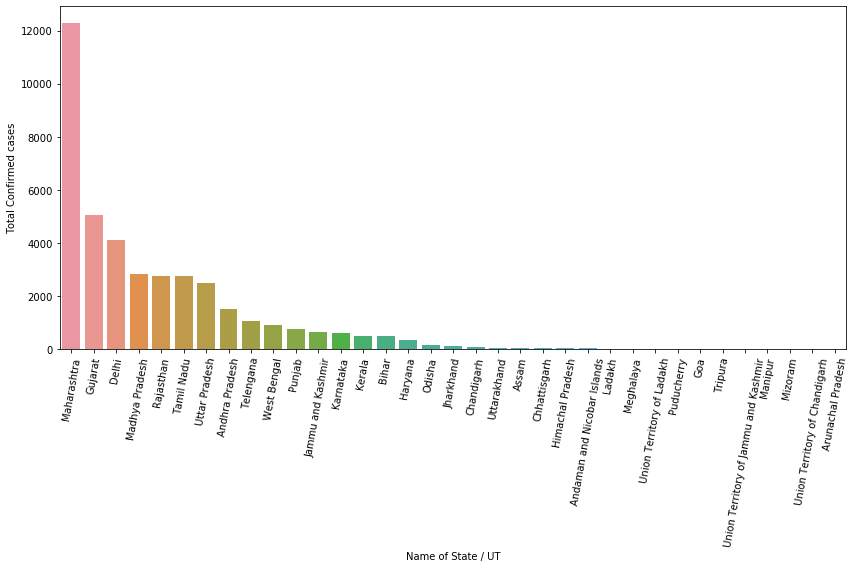

In [27]:
plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'Name of State / UT', y = 	'Total Confirmed cases',data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
plt.tight_layout()

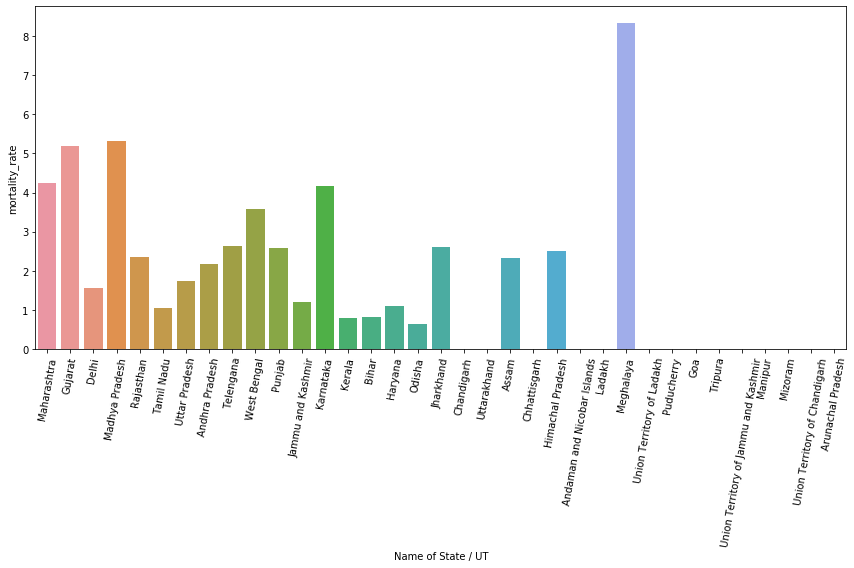

In [28]:
plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'Name of State / UT', y = 	'mortality_rate',data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
plt.tight_layout()

In [29]:
df.corr().style.background_gradient(cmap = 'Greens')

,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Latitude,Longitude,Death,Total Confirmed cases,mortality_rate
Total Confirmed cases (Indian National),1.000000,0.410054,0.679477,-0.339068,-0.417180,0.651529,0.689514,0.292669
Total Confirmed cases ( Foreign National ),0.410054,1.000000,0.292292,-0.235766,-0.280871,0.073757,0.137038,0.015773
Cured/Discharged/Migrated,0.679477,0.292292,1.000000,-0.233992,-0.414213,0.771910,0.906739,0.359972
Latitude,-0.339068,-0.235766,-0.233992,1.000000,-0.081900,-0.135117,-0.151970,-0.095972
Longitude,-0.417180,-0.280871,-0.414213,-0.081900,1.000000,-0.310721,-0.346821,-0.096372
Death,0.651529,0.073757,0.771910,-0.135117,-0.310721,1.000000,0.957385,0.463181
Total Confirmed cases,0.689514,0.137038,0.906739,-0.151970,-0.346821,0.957385,1.000000,0.416664
mortality_rate,0.292669,0.015773,0.359972,-0.095972,-0.096372,0.463181,0.416664,1.000000


In [30]:
ind_patient.head(2)

,patient_number,p_id,state_patient_number,date_announced,age_bracket,gender,detected_city,detected_district,detected_state,state_code,...,type_of_transmission,contracted_from_which_patient_suspected,status_change_date,current_status,estimated_onset_date,source1,source2,source3,notes,backup_notes
0,1,P1,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,KL,...,Imported,NaN,14/02/2020,Recovered,NaN,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Travelled from Wuhan,Student from Wuhan
1,2,P2,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,...,Imported,NaN,14/02/2020,Recovered,NaN,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Travelled from Wuhan,Student from Wuhan


In [31]:
ind_patient.columns

Index(['patient_number', 'p_id', 'state_patient_number', 'date_announced',
       'age_bracket', 'gender', 'detected_city', 'detected_district',
       'detected_state', 'state_code', 'nationality', 'type_of_transmission',
       'contracted_from_which_patient_suspected', 'status_change_date',
       'current_status', 'estimated_onset_date', 'source1', 'source2',
       'source3', 'notes', 'backup_notes'],
      dtype='object')

[Text(0, 0, 'Local'),
 Text(0, 0, 'TBD'),
 Text(0, 0, 'Imported'),
 Text(0, 0, 'Imported '),
 Text(0, 0, 'Unknown')]

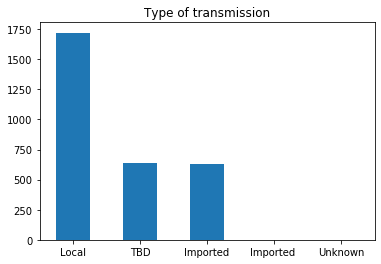

In [32]:
ax = ind_patient['type_of_transmission'].value_counts().plot(kind= 'bar', title = 'Type of transmission')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

In [33]:
ind_patient['detected_district'].value_counts()

Mumbai           2687
Ahmedabad        2181
Indore           1036
Jaipur            808
Pune              680
                 ... 
Other Region*       1
Balrampur           1
Kathua              1
Dohad               1
Beed                1
Name: detected_district, Length: 444, dtype: int64

In [34]:
df = ind_patient['age_bracket'].value_counts().sort_values()
df = df.reset_index()
df = df.rename(columns = {'index':'age','age_bracket':'number of patients'})

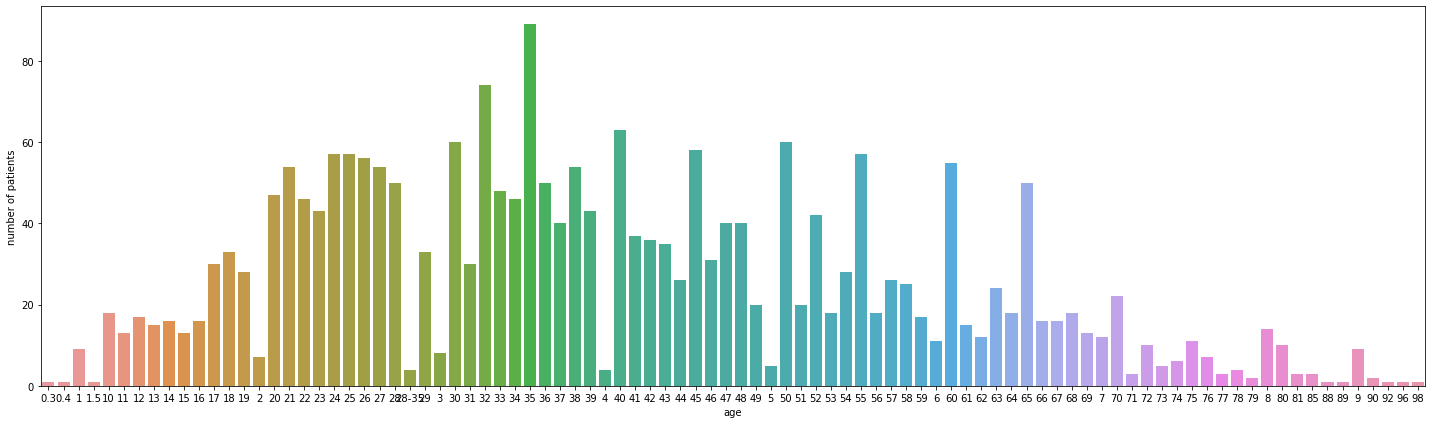

In [35]:
plt.figure(figsize = (20,6))
sns.barplot(x = 'age', y = 'number of patients',data = df.sort_values(by = 'age'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

In [36]:
df.sort_values('number of patients' , ascending = False).style.background_gradient(cmap = 'rainbow')

,age,number of patients
91,35,89
90,32,74
89,40,63
88,50,60
87,30,60
86,45,58
85,55,57
84,24,57
83,25,57
82,26,56


In [37]:
india_covid = india_covid[1:]
india_covid.head()

,Confirmed,Date,Deaths,mortality_rate,new_confirmed,new_deaths
1,0,2020-01-23,0,0.0,0,0
2,0,2020-01-24,0,0.0,0,0
3,0,2020-01-25,0,0.0,0,0
4,0,2020-01-26,0,0.0,0,0
5,0,2020-01-27,0,0.0,0,0


In [80]:
y = india_covid['Confirmed'].values

In [97]:
days = 10
X_train = np.arange(0,y.shape[0])
X_test = np.arange((y.shape[0]+1),(y.shape[0]+1+days))

In [98]:
polynomial_features= PolynomialFeatures(degree=3)
x_train_poly = polynomial_features.fit_transform(X_train.reshape(-1,1))
x_test_poly = polynomial_features.fit_transform(X_test.reshape(-1,1))

In [99]:
lm = LinearRegression()
lm.fit(x_train_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Predicting Covid cases for next 10 days

In [100]:
prediction = lm.predict(x_test_poly)

In [101]:
prediction = pd.DataFrame(prediction)

Text(0, 0.5, 'confirmed cases')

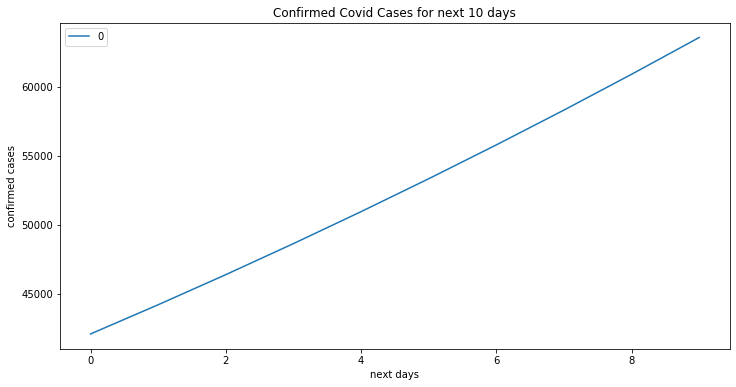

In [105]:
prediction.plot(figsize = (12,6), title ='Confirmed Covid Cases for next 10 days')
plt.xlabel( 'next days')
plt.ylabel('confirmed cases')

# Predicting Deaths in India for next 10 days

In [106]:
y = india_covid['Deaths'].values

Text(0, 0.5, 'Deaths')

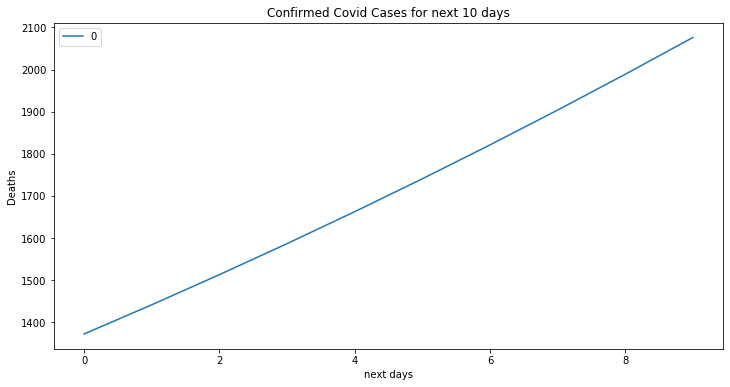

In [107]:
polynomial_features= PolynomialFeatures(degree=3)
x_train_poly = polynomial_features.fit_transform(X_train.reshape(-1,1))
x_test_poly = polynomial_features.fit_transform(X_test.reshape(-1,1))
lm = LinearRegression()
lm.fit(x_train_poly, y)
prediction = lm.predict(x_test_poly)
prediction = pd.DataFrame(prediction)
prediction.plot(figsize = (12,6), title ='Confirmed Covid Cases for next 10 days')
plt.xlabel( 'next days')
plt.ylabel('Deaths')